In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# define stoi 
stoi = {}
allletters = sorted(set("".join(words)))

stoi = {s:i+1 for i,s in enumerate(allletters)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [22]:
# dataset preparation 

X , Y = [], []
block_size= 3 # can be reset to whatever you like

for w in words:
    context = [0]*block_size # contains indcies of context letters
    for ch in w + '.':
        ix = stoi[ch]
        Y.append(ix) 
        X.append(context)
        context = context[1:] + [ix] # update context and append new index

X = torch.tensor(X)
Y = torch.tensor(Y)


In [7]:
g = torch.Generator().manual_seed(214748367)
# lookup matrix
C = torch.randn((27,2), generator=g)
# hidden layer - 100 neurons
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100,), generator=g)
# Output layer
W2 = torch.randn((100,27), generator=g )
b2 = torch.randn((27,), generator=g)

parameters = [C, W1, b1, W2, b2]

In [8]:
sum(p.nelement() for p in parameters) # total no of parameters in the network

3481

In [9]:
for p in parameters:
    p.requires_grad = True

Instead of training on entire dataset, lets run it on batches of size 32 each to make the training faster. 

modifications: $X\rightarrow X[ix]$, $Y\rightarrow Y[ix]$

__Consequences:__
- This will introduce some stochasticity and loss will not decrease uniformly. 
- The learning rate is a hyperparameter which we will tune. 
- Overall the time required to run batches will be much faster 
- Convergence to a loss may be slower and random

In [20]:
for  iter in range(30):

    ix = torch.randint(0, X.shape[0], (32,)) # assuming each batch has 32 data points 
    # Forward pass: 
    emb = C[X[ix]]
    H = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # 32,100
    logits = H @ W2 + b2
    loss = F.cross_entropy(logits, target=Y[ix])
    # Back pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data -= 0.1 * p.grad
    
print(loss.item())

2.5587151050567627


In [21]:
emb.shape

torch.Size([32, 3, 2])

Loss on full testset after minibatch GD:

In [13]:
# To the function more precise, can include W,b as arguments as well
def loss_fullset(A, B):
    emb_fullset = C[A] # 228146,3,2
    H = torch.tanh(emb_fullset.view(-1, 6) @ W1 + b1) # 228146,6 @ 6,100 => 228146, 100
    logits_fullset = H @ W2 + b2
    loss_fullset = F.cross_entropy(logits_fullset, target=B)
    return loss_fullset

# loss_fullset(X,Y)

Hence: using the parameters learnt from mini batchGD, loss on entire set is `2.8780`, which is not very far from the 2.5-3.0 range loss on the training batches. 

### Manual tuning for step size $\alpha$
One issue is that we don't know whether magnitude of step size $\alpha$ is too high or too low. Try $\alpha = [0.0001, 0.001, 0.01. 0.1, 1, 10]$ see at what values the loss explodes or becomes unstable and set them as limits. Refine iteratively. 

For our problem, $0.001 = 10^{-3}$ and $1 = 10^{0}$ prove to be good limits on $\alpha$. 

In [28]:
lre = torch.linspace(-3,0,1000) # 1000 exponents
lrs = 10**lre # list of learning rates 

__NOTE:__ rerun the cells where W,b,C are initialized and p.grad = True is set. 

In [29]:
lri = []
lossi = []

for iter in range(1000): 
    # 1000 mini batches of size 32 each 
    ix = torch.randint(0, X.shape[0], (32,)) # assuming each batch has 32 data points 
    # Forward pass: 
    emb = C[X[ix]]
    H = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # 32,100
    logits = H @ W2 + b2
    loss = F.cross_entropy(logits, target=Y[ix])
    # Back pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[iter]
    for p in parameters:
        p.data -= lr * p.grad
    # track loss
    lossi.append(loss.item())
    lri.append(lr)
    
    

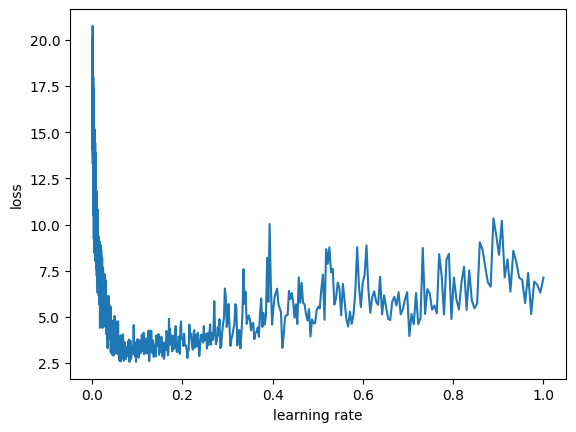

In [30]:
plt.plot(lri, lossi)
# plt.plot(lri, loss_full)
# plt.legend(title = "loss variation", loc = 'lower left')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.show()

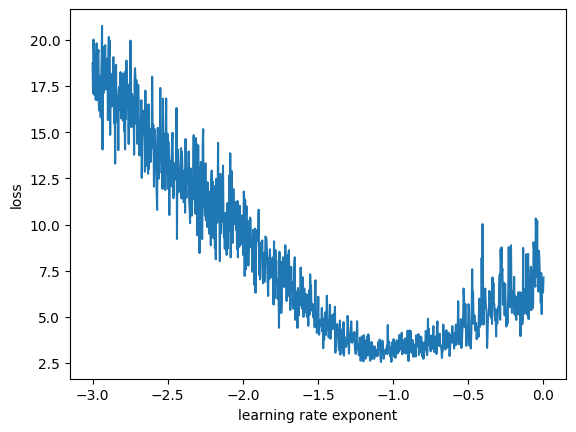

In [31]:
plt.plot(lre, lossi)
plt.xlabel('learning rate exponent')
plt.ylabel('loss')
plt.show()

From the two figures it is evident that least _training __batch__ loss_ is obtained somewhere around lr = $10^{-1}$ or lr = $0.1$

So you can run like 1000 iterations, 3 times for lr = $0.1$ then 3 more times for lr = $0.01$ and so on untill loss absolutely plateaus or set a custom termination criteria. (__a.k.a lr decay__)


## Motivation for train-dev-test split: 

1. The loss here pleateaus to abot `2.30` by applying lr decay from 1 to 0.1 to 0.01 for many thousand iterations. 
2. Bigram loss was ~ `2.45`
3. Having a lower loss may not necessarily mean a 'better model' or more 'name-like' names being predicted. 
4. Additionally we have control over the parameters in the network (no or neurons in hidden layer, embedding dimension) which if made too high risks overfitting on the training data. 
5. In say a `1000000` parameter case, the training loss will be very low, but it will not generalize well. 

Hence, <br>
We resport to the train-dev-test split to ensure the model generalizes better. See `CS229` notes for additional theoritical info.

__Training set:__ Find optimial model parameters ($W,b,C$) <br>
__Dev set:__ To optimize hyperparameters (size of hidden layer, embedding dimension, strength of regularization) <br>
__Test set:__ Report overall performance ONLY (sparingly)

In [4]:
def build_dataset(words1):
    X1 , Y1 = [], []
    block_size= 3 # can be reset to whatever you like

    for w in words1:
        context = [0]*block_size # contains indcies of context letters
        for ch in w + '.':
            ix = stoi[ch]
            Y1.append(ix) 
            X1.append(context)
            context = context[1:] + [ix] # update context and append new index

    X1 = torch.tensor(X1)
    Y1 = torch.tensor(Y1)
    print(X1.shape, Y1.shape)
    return X1,Y1

__Note__: n1, n2 are no of words, what is printed is no of datapoints from those words 

In [5]:
import random 

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*(len(words)))

print(n1,n2)
print('----------------')

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xt, Yt = build_dataset(words[n2:])

25626 28829
----------------
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Train on Xtr, Ytr:

In [19]:
for iter in range(1000): 
    # 1000 mini batches of size 32 each 
    ix = torch.randint(0, Xtr.shape[0], (32,)) # assuming each batch has 32 data points 
    # Forward pass: 
    emb = C[Xtr[ix]]
    H = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # 32,100
    logits = H @ W2 + b2
    loss = F.cross_entropy(logits, target=Ytr[ix])
    # Back pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad  
    

check loss on entire training set and dev set:

In [20]:
print(loss_fullset(Xtr, Ytr))
print(loss_fullset(Xdev, Ydev))


tensor(2.5636, grad_fn=<NllLossBackward0>)
tensor(2.5567, grad_fn=<NllLossBackward0>)


So from the above two losses which are pretty close, we are _not_ overfitting on training set!

It usually means that we have underfit. That our netword is too small to capture all data. 

## Hyperparameter tuning

1. We could change the size of the hidden layer to say 300, increasing parameters to ~10,000 and train for longer iterations with $\alpha$ = 0.1, 0.05, 0.01 and so on until loss stagnates. 

2. The size of the embedding may be a bottleneck. Perhaps a 2D mapping for each character is not enough, we need a higher dimensional embedding vector!

3. Size of the minibatch maybe be increased from 32 to say 100, if stochasticity is too high. 

4. Instead of 3 chars as context, take more 

These can be implemented as an exercise to play around. try gridsearch or smth maybe. 

Bengio et al also has more ideas for improvement. 

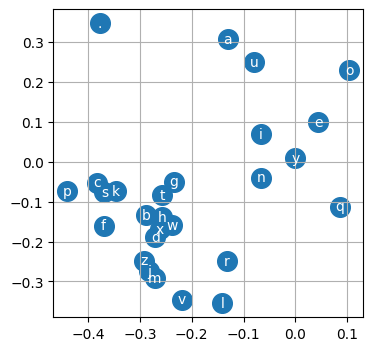

In [66]:
# visualize embedding:

plt.figure(figsize=(4,4))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

It is interesting to note that aeiou vowels are very close together; i.e. the model finds them similar or interchangeable in the data. 

In [23]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mri.
jamyan.
keel.
ndhey.
larethrs.
kadrleg.
adered.
elii.
smi.
jellekeisean.
nar.
kalekollara.
noshdbergihi.
jest.
kale.
jelilenteror.
uba.
ged.
ray.
jul.


__Note on best practices:__

Overall, this notebook to gain from proper restructuring to create classes and function of define and initalize variables, run iteration, plot graphs, sample names etc. 

Also, you _wouldn't hardcode dimensions etc in production_, rather have them be extracted directly from relevant variables. These could include dimension of embeddings, sizes of layers, .view() conversions etc. 

Finally: grande Andrej!